In [ ]:
import numpy as np
from numpy.random import rand
import seaborn as sns
import pandas as pd
from sklearn import tree
import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics 
from sklearn.model_selection import train_test_split
start = time.time()

In [ ]:
data = pd.read_csv("data.csv")
data  = data.values
feat  = np.asarray(data[:, 0:-1])
label = np.asarray(data[:, -1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feat, label, test_size=0.2, stratify=label)

In [ ]:
alpha  = 1      
beta0  = 1       
gamma  = 1      
theta  = 0.97    
b  = 1    
k    = 5     
N    = 57
T    = 10
fold = {'xt':X_train, 'yt':y_train, 'xv':X_test, 'yv':y_test}
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'alpha':alpha, 'beta0':beta0, 'gamma':gamma, 'theta':theta}

In [ ]:
def Fun(X_train, y_train, x, opts):
    alpha    = 0.99
    beta     = 1 - alpha
    max_feat = len(x)
    num_feat = np.sum(x == 1)
    if num_feat == 0:
        cost  = 1
    else:
        error = error_rate(X_train, y_train, x, opts)
        cost  = alpha * error + beta * (num_feat / max_feat)
        
    return cost

In [ ]:
def error_rate(X_train, y_train, x, opts):
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv']
    yv    = fold['yv']
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    X_train  = xt[:, x == 1]
    y_train  = yt.reshape(num_train) 
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  
    mdl     = KNeighborsClassifier(n_neighbors = k,metric='euclidean')
    #mdl     = KNeighborsClassifier(n_neighbors = k,metric='manhattan')
    #mdl     = KNeighborsClassifier(n_neighbors = k,metric='chebyshev')
    mdl.fit(X_train, y_train)
    #mdl     = DecisionTreeClassifier(criterion = "entropy", random_state = 0)
    #mdl.fit(X_train, y_train)
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc
    
    return error

In [ ]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X

In [ ]:
def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin

In [ ]:
def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x

In [ ]:
def jfs(X_train, y_train, opts):
    ub     = 1
    lb     = 0
    thres  = 0.5
    alpha  = 1       
    beta0  = 1       
    gamma  = 1       
    theta  = 0.97   
    N = opts['N']
    max_iter   = opts['T']
    if 'alpha' in opts:
        alpha  = opts['alpha'] 
    if 'beta0' in opts:
        beta0  = opts['beta0'] 
    if 'gamma' in opts:
        gamma  = opts['gamma'] 
    if 'theta' in opts:
        theta  = opts['theta'] 
    dim = np.size(X_train, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
    X     = init_position(lb, ub, N, dim)
    Xbin  = binary_conversion(X, thres, N, dim)
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    for i in range(N):
        fit[i,0] = Fun(X_train, y_train, Xbin[i,:], opts)
        if fit[i,0] < fitG:
            Xgb[0,:] = X[i,:]
            fitG     = fit[i,0]
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    curve[0,t] = fitG.copy()
    print("Generation:", t + 1)
    print("Best (FA):", curve[0,t])
    t += 1
        
    while t < max_iter:  
        alpha = alpha * theta
        ind   = np.argsort(fit, axis=0)
        FF    = fit.copy()
        XX    = X.copy()
        for i in range(N):
            fit[i,0] = FF[ind[i,0]]
            X[i,:]   = XX[ind[i,0],:]
        
        for i in range(N):
            for j in range(N):
                    if fit[i,0] > fit[j,0]: 
                     
                        r    = np.sqrt(np.sum((X[i,:] - X[j,:]) ** 2))
                    
                        beta = beta0 * np.exp(-gamma * r ** 2)
                        for d in range(dim):
                       
                            eps    = rand() - 0.5
                            X[i,d] = X[i,d] + beta * (X[j,d] - X[i,d]) + alpha * eps 

                            X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])

                    
                    temp      = np.zeros([1, dim], dtype='float')
                    temp[0,:] = X[i,:]  
                    Xbin      = binary_conversion(temp, thres, 1, dim)
                    
                   
                    fit[i,0]  = Fun(X_train, y_train, Xbin[0,:], opts)
                    
                           
                    if fit[i,0] < fitG:
                        Xgb[0,:] = X[i,:]
                        fitG     = fit[i,0]
        curve[0,t] = fitG.copy()
        print("Generation:", t + 1)
        print("Best (FA):", curve[0,t])
        t += 1            
      
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    fa_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return fa_data  


In [ ]:
time.sleep(1)
fmdl = jfs(feat, label, opts)
sf   = fmdl['sf']

Generation: 1
Best (FA): 0.1492350877192982
Generation: 2
Best (FA): 0.10816052631578946
Generation: 3
Best (FA): 0.10686140350877199
Generation: 4
Best (FA): 0.10408771929824559
Generation: 5
Best (FA): 0.10408771929824559
Generation: 6
Best (FA): 0.10408771929824559
Generation: 7
Best (FA): 0.10408771929824559
Generation: 8
Best (FA): 0.10408771929824559
Generation: 9
Best (FA): 0.09531140350877194
Generation: 10
Best (FA): 0.09531140350877194


In [ ]:
num_train = np.size(X_train, 0)
num_valid = np.size(X_test, 0)
print(len(X_train[0]))
x_train   = X_train[:, sf]
print(len(x_train[0]))
print(sf)
y_train   = y_train.reshape(num_train) 
x_valid   = X_test[:, sf]
y_valid   = y_test.reshape(num_valid)

57
26
[ 0  4  5  7  9 12 17 20 21 22 23 24 27 30 31 34 35 36 41 42 45 48 49 50
 53 54]


In [ ]:
feature = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_conference',
       'char_freq_%3B', 'char_freq_%28', 'char_freq_%5B', 'char_freq_%21',
       'char_freq_%24', 'char_freq_%23', 'capital_run_length_average',
       'capital_run_length_longest', 'capital_run_length_total', 'class']
print("-----------selected_features---------")
for i in sf:
  print(feature[i])

-----------selected_features---------
word_freq_make
word_freq_our
word_freq_over
word_freq_internet
word_freq_mail
word_freq_people
word_freq_email
word_freq_your
word_freq_font
word_freq_000
word_freq_money
word_freq_hp
word_freq_650
word_freq_telnet
word_freq_857
word_freq_85
word_freq_technology
word_freq_1999
word_freq_meeting
word_freq_original
word_freq_edu
char_freq_%3B
char_freq_%28
char_freq_%5B
char_freq_%23
capital_run_length_average


In [ ]:
mdl     = KNeighborsClassifier(n_neighbors = k,metric='euclidean')
#mdl     = KNeighborsClassifier(n_neighbors = k,metric='manhattan')
#mdl     = KNeighborsClassifier(n_neighbors = k,metric='chebyshev')
#mdl       = DecisionTreeClassifier(criterion = "entropy", random_state = 0)  
mdl.fit(x_train, y_train)
print(mdl.predict(x_valid))

[0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1.

In [ ]:
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
error = 1 - Acc
precision = metrics.precision_score(y_valid, y_pred, average = None)
recall = metrics.recall_score(y_valid, y_pred, average = None)
F1_score = metrics.f1_score(y_valid, y_pred, average = None)
print("Error = ", error , "\nPrecision =",precision,"\nRecall = ", recall,"\nF1 Score = ", F1_score)
print("Accuracy:", 100 * Acc)

Error =  0.09166666666666667 
Precision = [0.9301676  0.87603306] 
Recall =  [0.91735537 0.89451477] 
F1 Score =  [0.92371706 0.88517745]
Accuracy: 90.83333333333333


[[333  30]
 [ 25 212]]


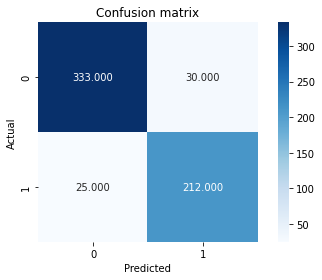

In [ ]:
conf_matrix = metrics.confusion_matrix(y_valid,y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.tight_layout()
print(conf_matrix)

In [ ]:
mdl       = DecisionTreeClassifier(criterion = "entropy", random_state = 0)  
path=mdl.cost_complexity_pruning_path(x_train,y_train)
ccp_alphas,impurities=path.ccp_alphas,path.impurities
print("ccp alpha wil give list of values :",ccp_alphas)
print("***********************************************************")
print("Impurities in Decision Tree :",impurities)
mdl.fit(x_train, y_train)
print(mdl.predict(x_valid))

ccp alpha wil give list of values : [0.         0.00114883 0.00150527 0.00162641 0.00166806 0.00178625
 0.00192795 0.0020314  0.002037   0.0020403  0.00229765 0.00229765
 0.00229765 0.00229765 0.00229765 0.00241873 0.00250209 0.00257269
 0.00264784 0.00270652 0.00275134 0.0027821  0.00280974 0.00284396
 0.00304535 0.00304544 0.0031619  0.00316679 0.00318898 0.00319752
 0.00323402 0.00330121 0.00333611 0.00339323 0.00359717 0.00372939
 0.00391156 0.00392348 0.00392781 0.00405144 0.004134   0.00419286
 0.00427385 0.00429585 0.00433466 0.00460511 0.00467269 0.00471391
 0.00482522 0.00495592 0.00500181 0.00511479 0.00517769 0.00527907
 0.00554171 0.00581416 0.00612346 0.00614165 0.00697118 0.00727132
 0.0083876  0.00896257 0.00911736 0.01262307 0.01482535 0.0150775
 0.01846625 0.01992824 0.02399527 0.02812645 0.03388111 0.03673129
 0.03816088 0.06346093 0.0773409  0.16747623]
***********************************************************
Impurities in Decision Tree : [0.         0.00229765 0.

In [ ]:
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
error = 1 - Acc
precision = metrics.precision_score(y_valid, y_pred, average = None)
recall = metrics.recall_score(y_valid, y_pred, average = None)
F1_score = metrics.f1_score(y_valid, y_pred, average = None)
print("Error = ", error , "\nPrecision =",precision,"\nRecall = ", recall,"\nF1 Score = ", F1_score)
print("Accuracy:", 100 * Acc)

Error =  0.13666666666666671 
Precision = [0.89952607 0.81208054] 
Recall =  [0.87144169 0.85091421] 
F1 Score =  [0.88526119 0.83104396]
Accuracy: 86.33333333333333


In [ ]:
mdls=[]
for ccp_alpha in ccp_alphas:
    mdl=DecisionTreeClassifier(criterion = "entropy",random_state=0,ccp_alpha=ccp_alpha)
    mdl.fit(x_train,y_train)
    mdls.append(mdl)
print("Last node in Decision tree is {} and ccp_alpha for last node is {}".format(mdls[-1].tree_.node_count,ccp_alphas[-1]))

Last node in Decision tree is 1 and ccp_alpha for last node is 0.16747622971481657


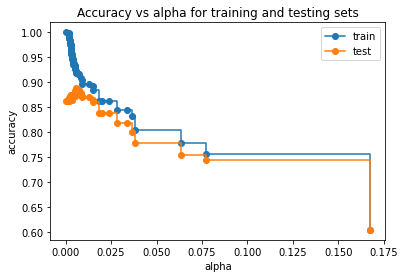

In [ ]:
train_scores = [mdl.score(x_train, y_train) for mdl in mdls]
test_scores = [mdl.score(x_valid, y_valid) for mdl in mdls]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",drawstyle="steps-post")
ax.legend()
plt.show()

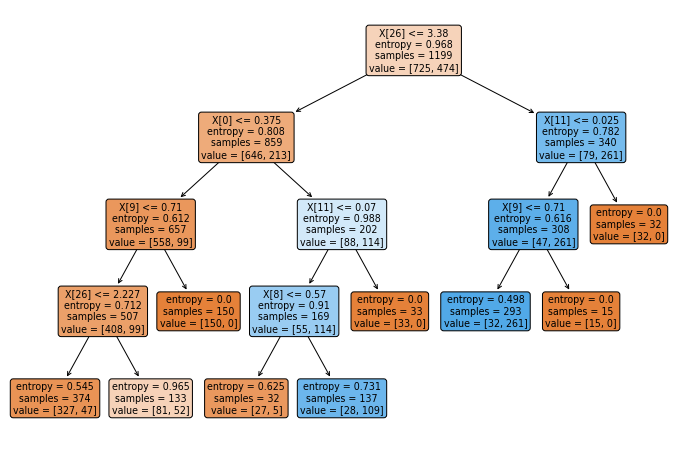

In [ ]:
mdl=DecisionTreeClassifier(criterion = "entropy",random_state=0,ccp_alpha=0.02)
mdl.fit(x_train,y_train)
plt.figure(figsize=(12,8))
tree.plot_tree(mdl,rounded=True,filled=True)
plt.show()

In [ ]:
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
error = 1 - Acc
precision = metrics.precision_score(y_valid, y_pred, average = None)
recall = metrics.recall_score(y_valid, y_pred, average = None)
F1_score = metrics.f1_score(y_valid, y_pred, average = None)
print("Error = ", error , "\nPrecision =",precision,"\nRecall = ", recall,"\nF1 Score = ", F1_score)
print("Accuracy:", 100 * Acc)

Error =  0.16166666666666663 
Precision = [0.84515571 0.82608696] 
Recall =  [0.89715335 0.74824191] 
F1 Score =  [0.87037862 0.78523985]
Accuracy: 83.83333333333334


In [ ]:
grid_param={"criterion":["gini","entropy"],
             "splitter":["best","random"],
             "max_depth":range(2,50,1),
             "min_samples_leaf":range(1,15,1),
             "min_samples_split":range(2,20,1) 
            }
grid_search=GridSearchCV(estimator=mdl,param_grid=grid_param,cv=5,n_jobs=4)
grid_search.fit(x_train,y_train)            

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(ccp_alpha=0.02,
                                              criterion='entropy',
                                              random_state=0),
             n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 50),
                         'min_samples_leaf': range(1, 15),
                         'min_samples_split': range(2, 20),
                         'splitter': ['best', 'random']})

In [ ]:
print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


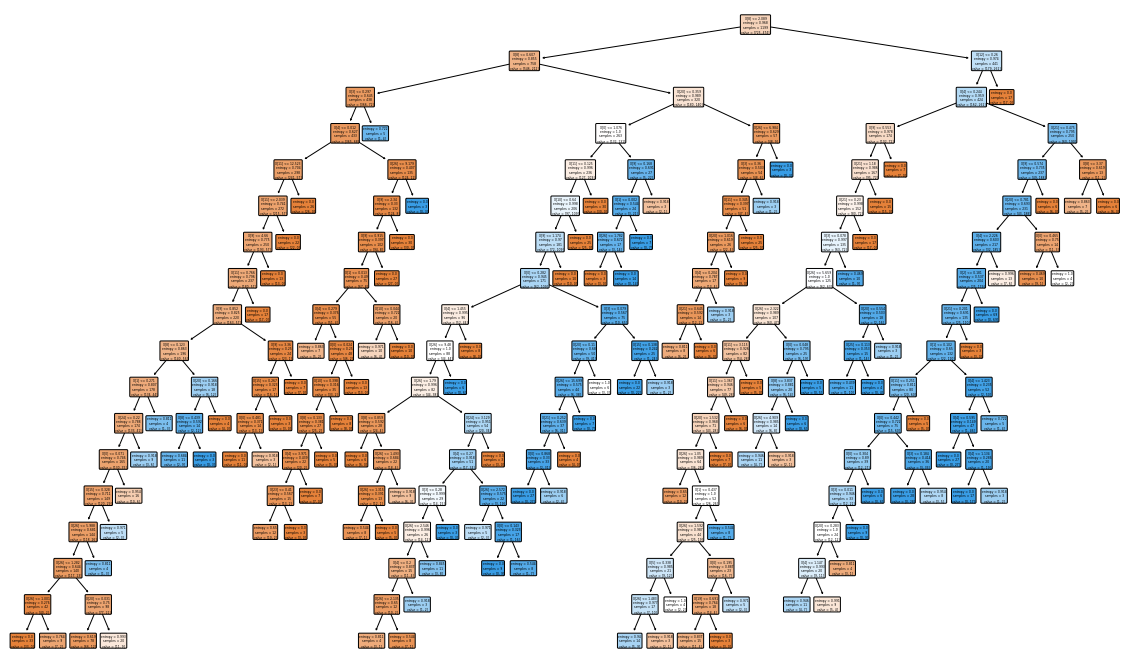

In [ ]:
mdl=DecisionTreeClassifier(criterion= 'entropy',max_depth= 17,min_samples_leaf= 3,min_samples_split= 12,splitter= 'random')
mdl.fit(x_train,y_train)
plt.figure(figsize=(20,12))
tree.plot_tree(mdl,rounded=True,filled=True)
plt.show()

In [ ]:
y_pred    = mdl.predict(x_valid)
Acc       = np.sum(y_valid == y_pred)  / num_valid
error = 1 - Acc
precision = metrics.precision_score(y_valid, y_pred, average = None)
recall = metrics.recall_score(y_valid, y_pred, average = None)
F1_score = metrics.f1_score(y_valid, y_pred, average = None)
print("Error = ", error , "\nPrecision =",precision,"\nRecall = ", recall,"\nF1 Score = ", F1_score)
print("Accuracy:", 100 * Acc)

Error =  0.17000000000000004 
Precision = [0.85112108 0.79562044] 
Recall =  [0.87144169 0.76652602] 
F1 Score =  [0.86116152 0.78080229]
Accuracy: 83.0


In [ ]:
num_feat = fmdl['nf']
print("Feature Size:", num_feat)
end = time.time()
c=end-start
print("Runtime of the program is ",c)

Feature Size: 26
Runtime of the program is  28.954012393951416


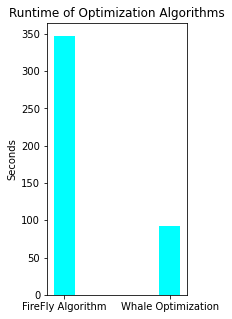

In [ ]:
data = {'FireFly Algorithm':347 ,"Whale Optimization":92.6777}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (2.5,5))
# creating the bar plot
plt.bar(courses, values, color ='cyan', width = 0.2)
plt.ylabel('Seconds')
plt.xlabel('')
plt.title("Runtime of Optimization Algorithms")
plt.show()

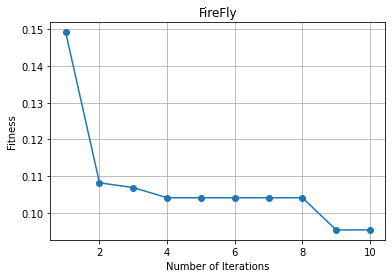

In [ ]:
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0
fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('FireFly')
ax.grid()
plt.show()